# Homework 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy.sparse.linalg import eigs
from scipy.sparse.linalg import LinearOperator

## Question 1: Energy spectrum of the Ising spin chain with PBC and APBC

Hamiltonian: $H(\theta) = -\cos \theta \sum \sigma_m^x \sigma_{m+1}^x - \sin\theta \sum \sigma_m^z$

In [2]:
def qIsingH_theta(N, theta, bc = 1): #bc = 1 PBC, =-1 APBC
    I = np.eye(2) #2x2 identity matrix
    X = np.array([[0,1],[1,0]]) #Pauli-X
    Z = np.array([[1,0],[0,-1]]) #Pauli-Z
    XX = np.kron(X,X) 
    
    H = -np.cos(theta)*XX - np.sin(theta)*(np.kron(Z,I) + np.kron(I,Z)) #Hamiltonian for N=2
    
    for n in range(3,(N+1)):
        H = np.kron(H,I)-np.cos(theta)*np.kron(np.eye(2**(n-2)),XX)- np.sin(theta)*np.kron(np.eye(2**(n-1)),Z)

    H = H - bc*np.cos(theta)*np.kron(X,np.kron(np.eye(2**(N-2)),X))
    
    return H

### Periodic Boundary Conditions

In [3]:
theta_max = np.pi/2 # range of magnetic field
theta_values = np.linspace(0,theta_max,20) #magnetic field values
bc = 1
N = 8

E_0_values = []
E_spectrums = []

for theta in theta_values:
    H = qIsingH_theta(N, theta, bc) #build the Hamiltonian
    D, U = np.linalg.eig(H)
    E_spectrums.append(np.sort(D))
    E_0_values.append(min(D)) #store the ground-state energy

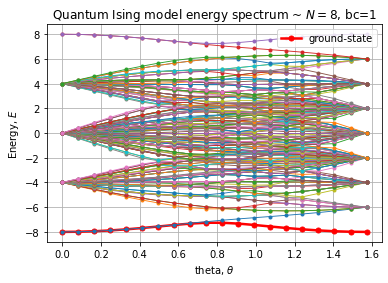

In [4]:
plt.title("Quantum Ising model energy spectrum ~ $N=$%s, bc=%s" %(N,bc))
plt.grid()
plt.ylabel(r"Energy, $E$")
plt.xlabel(r"theta, $\theta$")
plt.plot(theta_values, np.array(E_spectrums)[:,0], ls='-', marker='.', lw=2.5, ms=10, c="red", label="ground-state")
for i in range(1, np.shape(E_spectrums)[1]):
    plt.plot(theta_values, np.array(E_spectrums)[:,i], ls='-', marker='.', lw=0.9)
plt.legend()
plt.rcParams["figure.figsize"] = (16,8)
plt.show()

### Anti-Periodic Boundary Conditions

In [5]:
theta_max = np.pi/2 # range of magnetic field
theta_values = np.linspace(0,theta_max,20) #magnetic field values
bc = -1
N = 8

E_0_values = []
E_spectrums = []

for theta in theta_values:
    H = qIsingH_theta(N, theta, bc) #build the Hamiltonian
    D, U = np.linalg.eig(H)
    E_spectrums.append(np.sort(D))
    E_0_values.append(min(D)) #store the ground-state energy

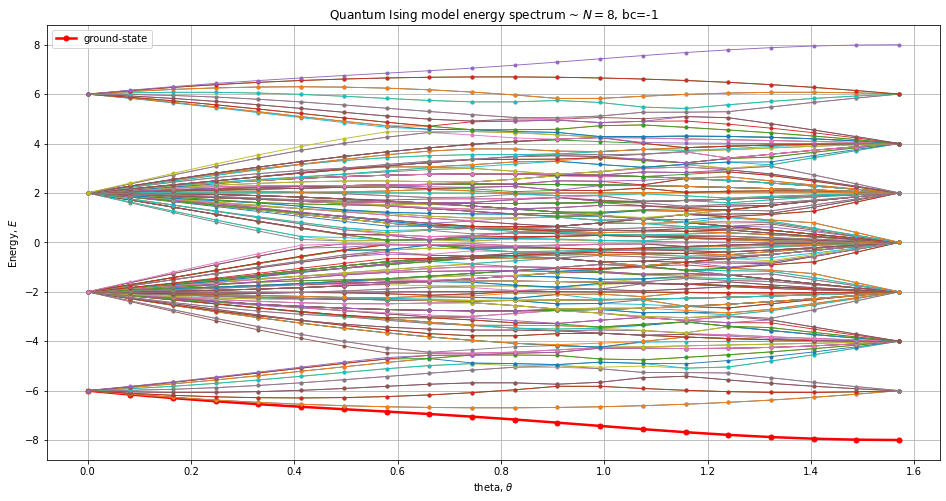

In [6]:
plt.title("Quantum Ising model energy spectrum ~ $N=$%s, bc=%s" %(N,bc))
plt.grid()
plt.ylabel(r"Energy, $E$")
plt.xlabel(r"theta, $\theta$")
plt.plot(theta_values, np.array(E_spectrums)[:,0], ls='-', marker='.', lw=2.5, ms=10, c="red", label="ground-state")
for i in range(1, np.shape(E_spectrums)[1]):
    plt.plot(theta_values, np.array(E_spectrums)[:,i], ls='-', marker='.', lw=0.9)
plt.legend()
plt.rcParams["figure.figsize"] = (16,8)
plt.show()

## Question 2: Low energy spectrum of the Ising spin chain with APBC

We follow the same prodecure as in Tutorial 3.<br>
We first define the necessary functions.

In [7]:
def qIsingH(N, h, bc = 1): #bc = 1 PBC, =-1 APBC
    I = np.eye(2) #2x2 identity matrix
    X = np.array([[0,1],[1,0]]) #Pauli-X
    Z = np.array([[1,0],[0,-1]]) #Pauli-Z
    XX = np.kron(X,X) 
    H = -XX - h*(np.kron(Z,I) + np.kron(I,Z)) #Hamiltonian for N=2
    
    for n in range(3,(N+1)):
        H = np.kron(H,I)-np.kron(np.eye(2**(n-2)),XX)-h*np.kron(np.eye(2**(n-1)),Z)

    H = H - bc*np.kron(X,np.kron(np.eye(2**(N-2)),X))
    
    return H

In [8]:
def T_op(N, APBC = True):
    SWAP = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) #SWAP operator
    I = np.eye(2)
    T = SWAP
    SWAP_N = SWAP #SWAP for N spins that we will build
    
    for n in range(3,(N+1)):
        T = np.kron(T,I)
        SWAP_N = np.kron(I, SWAP_N)
        T = T.dot(SWAP_N)
    
    if APBC:
        Z = np.array([[1,0],[0,-1]]) #Pauli-Z
        ZI = np.kron(Z, np.eye(2**(N-1)))
        T = ZI.dot(T)
        
    return T

In [9]:
def S_op(N):
    Z = np.array([[1,0],[0,-1]]) #Pauli-Z
    Z_2 = Z

    for n in range(2,(N+1)):
        Z_2 = np.kron(Z_2,Z)
        
    S = Z_2
    return S

Define $H_A$, $T_A$, $S$ and build linear combination Hamiltonian:

In [10]:
N = 10 #Hamiltonian will be 2^N x 2^N
h = 1

H_TFIM = qIsingH(N,h, bc = -1) #APBC quantum Ising
H_TFIM -= 4*N*np.eye(2**N) #make all eigenvalues negative
T = T_op(N, APBC = True)
S = S_op(N)

H_final = H_TFIM.dot(np.eye(2**N) + 0.001*T +0.00001*S)

Diagonalise for the 14 lowest energies:

In [11]:
num_states = 14

D, Psi = eigs(H_final, k = num_states, which = 'LM')

Obtain $E_\alpha$, $K_\alpha$ and $p_\alpha$:

In [12]:
E = np.real(np.diag((Psi.conj().T).dot(H_TFIM).dot(Psi))) + 4*N #shift back
k = np.angle(np.diag((Psi.conj().T).dot(T).dot(Psi)))
p = np.diag((Psi.conj().T).dot(S).dot(Psi))
p = abs(np.real(((1-p)/2).round()))

#sort from smaller to largest
ord_idx = np.argsort(E)
E = E[ord_idx]
k = k[ord_idx] 
p = p[ord_idx]

In [13]:
print('Energies: %s \nMomentum: %s' %(E, k))

Energies: [-12.62750303 -12.15916858 -12.15916858 -11.39143505 -11.39143505
 -10.96894444 -10.96894444 -10.27636202 -10.27636202 -10.15536707
  -9.95647932  -9.95647932  -9.71746872  -9.71746872] 
Momentum: [ 0.         -0.31415927  0.31415927 -0.62831853  0.62831853 -0.9424778
  0.9424778  -1.25663706  1.25663706  0.         -1.57079633  1.57079633
 -0.9424778   0.9424778 ]


## Question 3: Conformal data from the critical Ising spin chain with APBC

In the Homework we derived the relation: $\Delta_{\alpha} = 2\frac{E_{\alpha}-E_0^{PBC}}{E_T^{PBC}-E_0^{PBC}}$.

To be able to use this we will numerically obtain $E_0^{PBC}$ and $E_T^{PBC}$ from the PBC model in the cell below:

In [14]:
N = 10 #Hamiltonian will be 2^N x 2^N
h = 1

H_TFIM = qIsingH(N,h) #PBC quantum Ising
H_TFIM -= 4*N*np.eye(2**N) #make all eigenvalues negative
T = T_op(N, APBC = False)
S = S_op(N)

H_final = H_TFIM.dot(np.eye(2**N) + 0.001*T +0.00001*S)
D, Psi = eigs(H_final, k = 12, which = 'LM')

E_PBC = np.real(np.diag((Psi.conj().T).dot(H_TFIM).dot(Psi))) + 4*N #shift back
k_PBC = np.angle(np.diag((Psi.conj().T).dot(T).dot(Psi)))

#sort from smaller to largest
ord_idx = np.argsort(E_PBC)
E_PBC = E_PBC[ord_idx]
k_PBC = k_PBC[ord_idx] 

#obtain the eigenstate number corresponding to k_T to obtain E_T
k_T = 4*np.pi/N
N_T = 0
for n in range(12):
    if abs(k_PBC[n]-k_T) < 1e-4:
        if N_T == 0:
            N_T = n
print("Stress-energy tensor eigenvalue number:", N_T)

Stress-energy tensor eigenvalue number: 6


In [15]:
scaling_dim = 2*(E-E_PBC[0])/(E_PBC[N_T]-E_PBC[0])
conf_spin = k/(2*np.pi)*N
print('Scaling dimension: %s \nConformal spin: %s' %(scaling_dim, conf_spin))

Scaling dimension: [0.12892937 0.51254282 0.51254282 1.1413945  1.1413945  1.48745718
 1.48745718 2.05475248 2.05475248 2.15385962 2.31676888 2.31676888
 2.51254282 2.51254282] 
Conformal spin: [ 0.  -0.5  0.5 -1.   1.  -1.5  1.5 -2.   2.   0.  -2.5  2.5 -1.5  1.5]


In [16]:
th_scaling_dim = [1/8, 1/2, 1/2, 1+1/8, 1+1/8, 1+1/2, 1+1/2, 2+1/8, 2+1/8, 2+1/8, 2+1/2, 2+1/2, 2+1/2, 2+1/2]
th_parity = [0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1]
th_conf_spin = [0, -0.5, 0.5, -1, 1, -1.5, 1.5, -2, 2, 0, -2.5, 2.5, -1.5,  1.5]

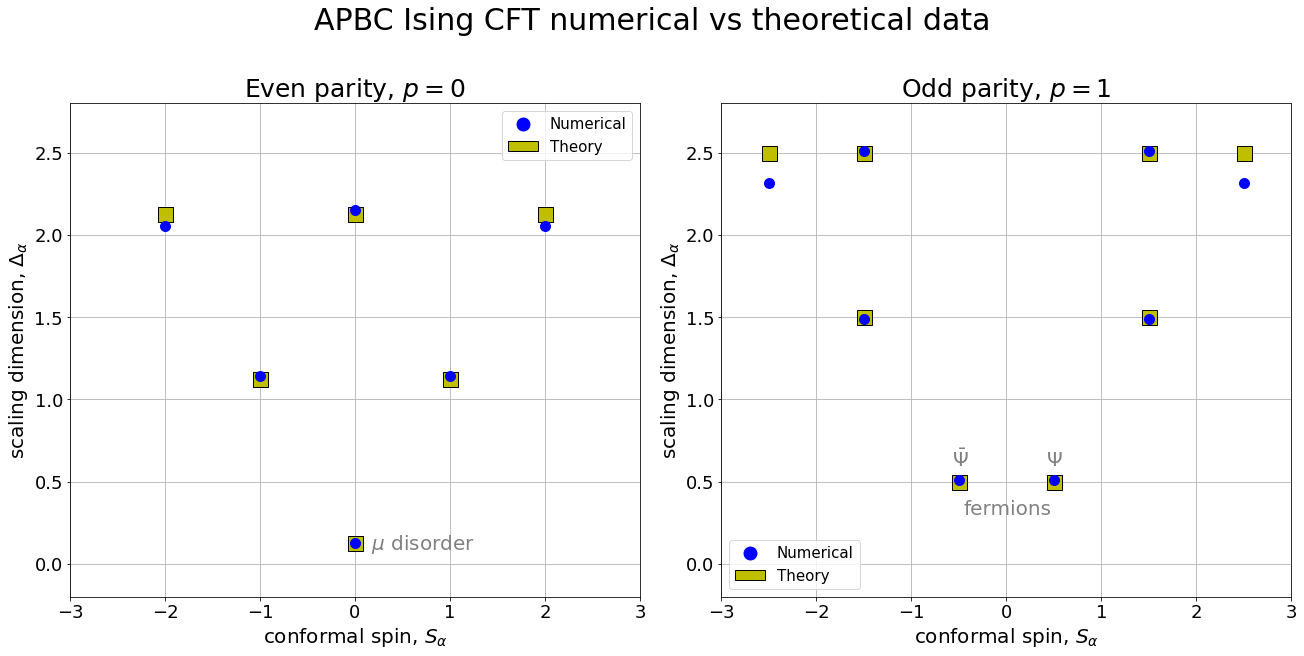

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, layout="constrained", figsize=(18, 9))
fig.suptitle('APBC Ising CFT numerical vs theoretical data\n', fontsize=30)
ax1.set_xlabel(r"conformal spin, $S_{\alpha}$", fontsize=20)
ax2.set_xlabel(r"conformal spin, $S_{\alpha}$", fontsize=20)
ax1.set_ylabel(r"scaling dimension, $\Delta_{\alpha}$", fontsize=20)
ax2.set_ylabel(r"scaling dimension, $\Delta_{\alpha}$", fontsize=20)
ax1.set_title(r'Even parity, $p=0$', fontsize=25)
ax2.set_title(r'Odd parity, $p=1$', fontsize=25)
ax1.tick_params(axis='both', labelsize=18)
ax2.tick_params(axis='both', labelsize=18)
ax1.grid()
ax2.grid()
ax1.set_xlim([-3, 3])
ax2.set_xlim([-3, 3])
ax1.set_ylim([-0.2, 2.8])
ax2.set_ylim([-0.2, 2.8])
ax1.text(0.17,0.09,r"$\mu$ disorder", fontsize=20, color='grey')
ax2.text(0.42,0.6,r"$\Psi$", fontsize=20, color='grey')
ax2.text(-0.57,0.6,r"$\bar{\Psi}$", fontsize=20, color='grey')
ax2.text(-0.45,0.3,"fermions", fontsize=20, color='grey')

for i in range(len(th_parity)):
    if th_parity[i] == 0:
        ax1.plot(th_conf_spin[i], th_scaling_dim[i], marker = "s", color = "y", markeredgecolor= "black", ms=15)
    elif th_parity[i] == 1:
        ax2.plot(th_conf_spin[i], th_scaling_dim[i], marker = "s", color = "y", markeredgecolor= "black", ms=15)


for i in range(num_states):
    if p[i] == 0:
        ax1.plot(conf_spin[i], scaling_dim[i], marker = "o", color = "b", ms=10)
    elif p[i] == 1:
        ax2.plot(conf_spin[i], scaling_dim[i], marker = "o", color = "b", ms=10)

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Numerical',
                          markerfacecolor='b', markersize=15),
                   Patch(facecolor='y', edgecolor='black',
                         label='Theory')]

        
ax1.legend(handles=legend_elements, fontsize=15)
ax2.legend(handles=legend_elements, fontsize=15)

## Question 4: Larger system sizes using LinearMap and eigs

Define local Hamiltonian unit:

In [18]:
def qIsingH_2(h, bc=1):
    I = np.eye(2) #2x2 identity matrix
    X = np.array([[0,1],[1,0]]) #Pauli-X
    Z = np.array([[1,0],[0,-1]]) #Pauli-Z
    XX = np.kron(X,X) 
    
    #Hamiltonian for N=2 but with factor of 1/2 in field term since each spin will appear twice
    H = -bc*XX - (h/2)*(np.kron(Z,I) + np.kron(I,Z)) 
    
    return H

In [19]:
H_2 = qIsingH_2(h=1, bc=1) #local PBC term
D, U = np.linalg.eig(H_2) #diagonalise fully
E_shift = np.sort(D)[-1]
H_2 -= E_shift*np.eye(4)
print("Local H PBC term:\n",np.round(H_2,2),'\n')

H_2_A = qIsingH_2(h=1, bc=-1) #local APBC term
D, U = np.linalg.eig(H_2_A) #diagonalise fully
E_shift = np.sort(D)[-1]
H_2_A -= E_shift*np.eye(4)
print("Local H APBC term:\n", np.round(H_2_A,2))

Local H PBC term:
 [[-2.41  0.    0.   -1.  ]
 [ 0.   -1.41 -1.    0.  ]
 [ 0.   -1.   -1.41  0.  ]
 [-1.    0.    0.   -0.41]] 

Local H APBC term:
 [[-2.41  0.    0.    1.  ]
 [ 0.   -1.41  1.    0.  ]
 [ 0.    1.   -1.41  0.  ]
 [ 1.    0.    0.   -0.41]]


In [20]:
def sparse_multiplication_TH(Psi):
    L = len(Psi)  # Dimension of the vector space
    N = round(np.log2(L))  # Number of spins
    HPsi = np.zeros(L)
    #PBC part
    for n in range(1, N):
        Psi = np.reshape(Psi,(4,2**(N-2)))
        HPsi = np.reshape(HPsi,(4,2**(N-2)))
        HPsi += H_2.dot(Psi)                 
        Psi = np.reshape(Psi,(2,2**(N-1)))
        HPsi = np.reshape(HPsi,(2,2**(N-1)))
        Psi = Psi.transpose(1,0)
        HPsi = HPsi.transpose(1,0)
    #APBC part
    Psi = np.reshape(Psi,(4,2**(N-2)))
    HPsi = np.reshape(HPsi,(4,2**(N-2)))
    HPsi += H_2_A.dot(Psi)                 
    Psi = np.reshape(Psi,(2,2**(N-1)))
    HPsi = np.reshape(HPsi,(2,2**(N-1)))
    Psi = Psi.transpose(1,0)
    HPsi = HPsi.transpose(1,0)
    
    Z = np.array([[1,0],[0,-1]])
    TPsi = Z.dot(np.reshape(Psi,(2,2**(N-1))))
    TPsi = TPsi.transpose(1,0) #action of T 
    
    TPsi = np.reshape(TPsi, L)
    HPsi = np.reshape(HPsi, L)
    
    HPsi_f = HPsi + 0.001*TPsi
    return HPsi_f

In [21]:
def evaluate_E(Psi, H, H_A):
    L = len(Psi)  # Dimension of the vector space
    N = round(np.log2(L))  # Number of spins
    HPsi = np.zeros(L)
    H = H.astype('complex128')
    for n in range(1, N):
        Psi = np.reshape(Psi,(4,2**(N-2)))
        HPsi = np.reshape(HPsi,(4,2**(N-2)))
        HPsi = HPsi+ H.dot(Psi)                 
        Psi = np.reshape(Psi,(2,2**(N-1)))
        HPsi = np.reshape(HPsi,(2,2**(N-1)))
        Psi = Psi.transpose(1,0)
        HPsi = HPsi.transpose(1,0)
    
    Psi = np.reshape(Psi,(4,2**(N-2)))
    HPsi = np.reshape(HPsi,(4,2**(N-2)))
    HPsi = HPsi+ H_A.dot(Psi)                 
    Psi = np.reshape(Psi,(2,2**(N-1)))
    HPsi = np.reshape(HPsi,(2,2**(N-1)))
    Psi = Psi.transpose(1,0)
    HPsi = HPsi.transpose(1,0)
    
    Psi = np.reshape(Psi, L)
    HPsi = np.reshape(HPsi, L)
    
    E = np.real(Psi.conj().T.dot(HPsi))
    
    return E

def evaluate_k(Psi):
    L = len(Psi)  # Dimension of the vector space
    N = round(np.log2(L))  # Number of spins
    Z = np.array([[1,0],[0,-1]])
    TPsi = Z.dot(np.reshape(Psi, (2,2**(N-1))))
    TPsi = TPsi.transpose(1,0) #action of T operator
    TPsi = np.reshape(TPsi, L)
    
    k = np.angle(Psi.conj().T.dot(TPsi))

    return k

def evaluate_p(Psi):
    L = len(Psi)  # Dimension of the vector space
    N = round(np.log2(L))  # Number of spins
    SPsi = Psi
    Z = np.array([[1,0],[0,-1]])
    
    for n in range(1, (N+1)):
        SPsi = np.reshape(SPsi,(2,2**(N-1)))
        SPsi = Z.dot(SPsi)               
        SPsi = SPsi.transpose(1,0)
    
    SPsi = np.reshape(SPsi, L)
    
    p = np.round((1 - np.real(Psi.conj().T.dot(SPsi)))/2)
    
    return p

In [22]:
N = 20

TH = LinearOperator((2**N,2**N), matvec = sparse_multiplication_TH)

In [23]:
num_states = 14
from scipy.sparse.linalg import eigs
D, Psi = eigs(TH, k = num_states, which = 'LM')

In [24]:
E = []
k = []
p = []

for state in range(num_states):
    E.append(evaluate_E(Psi[:,state], H_2, H_2_A))
    k.append(evaluate_k(Psi[:,state]))
    p.append(evaluate_p(Psi[:,state]))
    
#sort from smaller to largest
ord_idx = np.argsort(E)
E = np.array(E)[ord_idx]
k = np.array(k)[ord_idx] 
p = np.array(p)[ord_idx]

In [25]:
#values obtained from Tutorial 4
E_PBC_0 = -53.775260933826736
E_PBC_NT = -52.527643095491754
scaling_dim = 2*(E-E_PBC_0)/(E_PBC_NT-E_PBC_0)
conf_spin = k/(2*np.pi)*N
print('Scaling dimension: %s \nConformal spin: %s' %(scaling_dim, conf_spin))

Scaling dimension: [0.1259684  0.50309698 0.50309698 1.1290606  1.1290606  1.49690302
 1.49690302 2.10745334 2.10745334 2.1321528  2.45385034 2.45385034
 2.50309698 2.50309698] 
Conformal spin: [ 0.   0.5 -0.5  1.  -1.   1.5 -1.5  2.  -2.   0.   2.5 -2.5  1.5 -1.5]


In [26]:
th_scaling_dim = [1/8, 1/2, 1/2, 1+1/8, 1+1/8, 1+1/2, 1+1/2, 2+1/8, 2+1/8, 2+1/8, 2+1/2, 2+1/2, 2+1/2, 2+1/2]
th_parity = [0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1]
th_conf_spin = [0, -0.5, 0.5, -1, 1, -1.5, 1.5, -2, 2, 0, -2.5, 2.5, -1.5,  1.5]

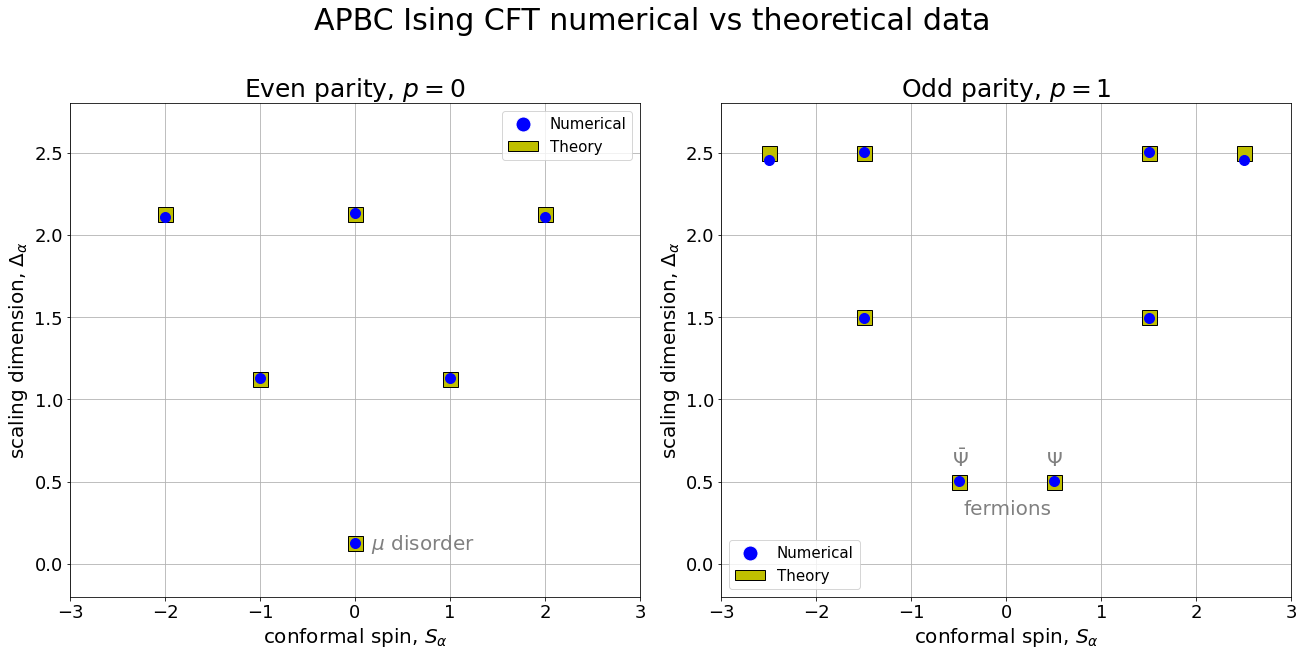

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, layout="constrained", figsize=(18, 9))
fig.suptitle('APBC Ising CFT numerical vs theoretical data\n', fontsize=30)
ax1.set_xlabel(r"conformal spin, $S_{\alpha}$", fontsize=20)
ax2.set_xlabel(r"conformal spin, $S_{\alpha}$", fontsize=20)
ax1.set_ylabel(r"scaling dimension, $\Delta_{\alpha}$", fontsize=20)
ax2.set_ylabel(r"scaling dimension, $\Delta_{\alpha}$", fontsize=20)
ax1.set_title(r'Even parity, $p=0$', fontsize=25)
ax2.set_title(r'Odd parity, $p=1$', fontsize=25)
ax1.tick_params(axis='both', labelsize=18)
ax2.tick_params(axis='both', labelsize=18)
ax1.grid()
ax2.grid()
ax1.set_xlim([-3, 3])
ax2.set_xlim([-3, 3])
ax1.set_ylim([-0.2, 2.8])
ax2.set_ylim([-0.2, 2.8])
ax1.text(0.17,0.09,r"$\mu$ disorder", fontsize=20, color='grey')
ax2.text(0.42,0.6,r"$\Psi$", fontsize=20, color='grey')
ax2.text(-0.57,0.6,r"$\bar{\Psi}$", fontsize=20, color='grey')
ax2.text(-0.45,0.3,"fermions", fontsize=20, color='grey')

for i in range(len(th_parity)):
    if th_parity[i] == 0:
        ax1.plot(th_conf_spin[i], th_scaling_dim[i], marker = "s", color = "y", markeredgecolor= "black", ms=15)
    elif th_parity[i] == 1:
        ax2.plot(th_conf_spin[i], th_scaling_dim[i], marker = "s", color = "y", markeredgecolor= "black", ms=15)


for i in range(num_states):
    if p[i] == 0:
        ax1.plot(conf_spin[i], scaling_dim[i], marker = "o", color = "b", ms=10)
    elif p[i] == 1:
        ax2.plot(conf_spin[i], scaling_dim[i], marker = "o", color = "b", ms=10)

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Numerical',
                          markerfacecolor='b', markersize=15),
                   Patch(facecolor='y', edgecolor='black',
                         label='Theory')]

        
ax1.legend(handles=legend_elements, fontsize=15)
ax2.legend(handles=legend_elements, fontsize=15)

## Question 5: Scaling of Entanglement Entropy in Ground States of local Hamiltonians

In [28]:
def entanglement_entropy_from_p(p):
    entropy = np.sum(np.array([-p_i*np.log2(p_i) for p_i in p if p_i > 0]))
    return entropy

def entropies_and_spectra_from_psi(Psi):
    L = len(Psi)  # Dimension of the vector space
    N = round(np.log2(L))  # Number of sites
    p = N//2 # N/2 or (N-1)/2 partitions -> 2**p is the most number of eigenvalues rho can have
    EE = np.zeros(p) #entanglement entropy
    ES = np.zeros((2**p, p)) #entanglement spectrum
    for n in range(1,p+1):
        M = np.reshape(Psi, (2**(n),2**(N-n))) #partition into 2 subsystems to create matrix
        rho = M.dot(M.conj().T) #reduced density matrix
        p, U = np.linalg.eig(rho) #obtain eivenvalues p_i
        p = np.real(p) # to remove imaginary parts
        p_sorted = -np.sort(-p) #sort
        #fill with zeros to get size 2**(N//2)
        pad_w = 2**(N//2)-2**n 
        p = np.pad(p, (0, pad_w), 'constant')
        #store
        ES[:,n-1] = p  
        EE[n-1] = entanglement_entropy_from_p(p)
    return ES,EE

In [29]:
theta_max = np.pi/2 # range of magnetic field
num = 5
theta_values = np.linspace(0,theta_max,num) #magnetic field values
theta_values_str = [0]
theta_values_str += [r"$\pi$"+"/"+str(np.round(np.pi/theta,2)) for theta in theta_values[1::]]
bc = 1
N = 10

In [30]:
entropies_gs = [[] for i in range(len(theta_values))]

for i, theta in enumerate(theta_values):
    H = qIsingH_theta(N, theta, bc) #build the Hamiltonian
    D, U = np.linalg.eig(H)
    _, entropies_gs[i] = entropies_and_spectra_from_psi(U[:,0])

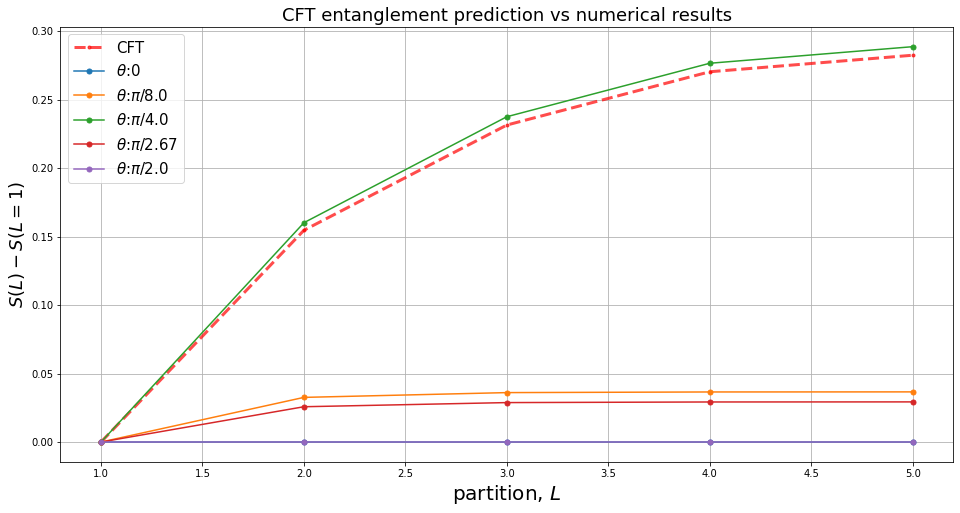

In [31]:
cft_ent_entropy = [1/6*(np.log2(N/np.pi*np.sin(n*np.pi/N))-np.log2(N/np.pi*np.sin(np.pi/N))) for n in range (1,N//2+1)]
plt.title("CFT entanglement prediction vs numerical results", fontsize=18)
plt.grid()
plt.xlabel(r"partition, $L$", fontsize=20)
plt.ylabel(r"$S(L)-S(L=1)$",fontsize=18)
x = [i for i in range(1, len(cft_ent_entropy)+1)]
plt.plot(x, cft_ent_entropy, ".", ls='--', color = 'r', lw = 3, label = "CFT",alpha=0.7)
for i, ent_entropy_gs in enumerate(entropies_gs):
    plt.plot(x, ent_entropy_gs-ent_entropy_gs[0], ".", ls='-', ms = 10, label = r"$\theta$:" + str(theta_values_str[i]))
plt.legend(fontsize=15)
plt.show()

### $\theta = \pi/4$ (critical system) matches with CFT entanglement scaling expectation!